Epoch 0, Loss: 1.0557
Epoch 10, Loss: 1.0048
Epoch 20, Loss: 0.9985
Epoch 30, Loss: 0.9890
Epoch 40, Loss: 0.9660
Epoch 50, Loss: 0.9141
Epoch 60, Loss: 0.8246
Epoch 70, Loss: 0.7024
Epoch 80, Loss: 0.5812
Epoch 90, Loss: 0.5028
Epoch 100, Loss: 0.4592
Epoch 110, Loss: 0.4370
Epoch 120, Loss: 0.4314
Epoch 130, Loss: 0.4214
Epoch 140, Loss: 0.4178
Epoch 150, Loss: 0.4164
Epoch 160, Loss: 0.4184
Epoch 170, Loss: 0.4142
Epoch 180, Loss: 0.4107
Epoch 190, Loss: 0.4084
Epoch 200, Loss: 0.4052
Epoch 210, Loss: 0.3992
Epoch 220, Loss: 0.3970
Epoch 230, Loss: 0.3930
Epoch 240, Loss: 0.3972
Epoch 250, Loss: 0.3894
Epoch 260, Loss: 0.3877
Epoch 270, Loss: 0.3740
Epoch 280, Loss: 0.3728
Epoch 290, Loss: 0.3630


C:\Users\katel\anaconda3\envs\mTBI-MLP\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.87      0.87      0.87        15

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32

Accuracy: 0.8750
Precision: 0.8667
Recall: 0.8667
F1-Score: 0.8667
AUC: 0.8824

Confusion Matrix:
[[15  2]
 [ 2 13]]


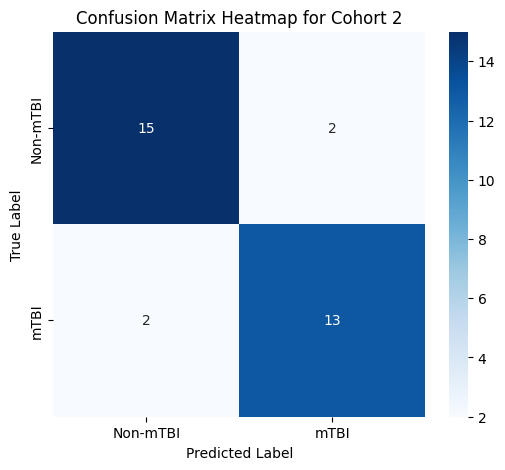

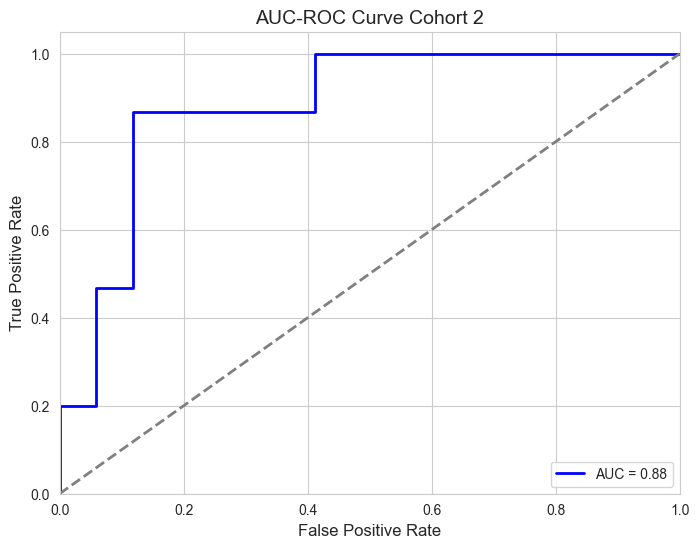


5-Fold Cross-Validation AUC:
Fold 1 AUC: 0.7368
Fold 2 AUC: 0.8377
Fold 3 AUC: 0.9017
Fold 4 AUC: 0.8333
Fold 5 AUC: 0.9145

Mean AUC across folds: 0.8448 ± 0.0631


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# import cohort 2
cohort_2 = pd.read_csv("ExternalTBIData.csv")
cohort_2_filtered = cohort_2.drop(index=[59, 62, 63, 64, 67, 79, 81, 83])
cohort_2_filtered = cohort_2_filtered.drop(columns=['SampleID']) 
cohort_2_filtered = cohort_2_filtered.reset_index(drop=True)

# split data training/testing
X = cohort_2_filtered.drop(columns=['GroupNo'])  
y = cohort_2_filtered['GroupNo'].values  # Ensure y is a NumPy array

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std * 0.05  # Reduce randomness

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# dataset to PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# VAE
input_dim = X.shape[1]
vae = VAE(input_dim, latent_dim=10)
optimizer = optim.Adam(vae.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()

# train VAE
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed, mu, log_var = vae(X_tensor)
    reconstruction_loss = loss_fn(reconstructed, X_tensor)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) * 0.005
    loss = reconstruction_loss + kl_divergence
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# generate synthetic data (identified through cross-validation optimization algorithm)
num_synthetic_samples = 50
z_sample = torch.randn((num_synthetic_samples, 10))
synthetic_data = vae.decoder(z_sample).detach().numpy()
unique_classes, class_counts = np.unique(y, return_counts=True)
class_probabilities = class_counts / class_counts.sum()
y_synthetic = np.random.choice(unique_classes, size=num_synthetic_samples, p=class_probabilities)
X_extended = np.vstack([X_scaled, synthetic_data])
y_extended = np.concatenate([y, y_synthetic])

# apply SMOTE
smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# add synthetic data to SMOTE
X_resampled = np.vstack([X_resampled, synthetic_data])
y_resampled = np.concatenate([y_resampled, y_synthetic])


# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)

# LASSO
lasso = Lasso(alpha=0.02)
lasso.fit(X_train, y_train)
selected_features = lasso.coef_ != 0
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=3000, 
                          alpha=0.8, solver='adam', random_state=seed, learning_rate_init=0.0001)
mlp_model.fit(X_train_selected, y_train)

# evaluate
y_test_proba = mlp_model.predict_proba(X_test_selected)[:, 1]
y_test_pred = (y_test_proba >= 0.92).astype(int)  # Using a threshold of 0.85

# evaluation metrics
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


# conf matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-mTBI', 'mTBI'], 
            yticklabels=['Non-mTBI', 'mTBI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap for Cohort 2')
plt.show()

# manual threshold value for precision
from sklearn.metrics import precision_recall_curve
y_test_pred = (y_test_proba >= 0.92).astype(int)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# using seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.2f}')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('AUC-ROC Curve Cohort 2', fontsize=14)
plt.legend(loc='lower right')
plt.show()
# 5-fold cross-validation for AUC

print("\n5-Fold Cross-Validation AUC:")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled[:, selected_features], y_resampled)):
    X_fold_train, X_fold_val = X_resampled[train_idx][:, selected_features], X_resampled[val_idx][:, selected_features]
    y_fold_train, y_fold_val = y_resampled[train_idx], y_resampled[val_idx]

    fold_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=3000, 
                              alpha=0.8, solver='adam', random_state=seed, learning_rate_init=0.0001)
    fold_mlp.fit(X_fold_train, y_fold_train)

    y_val_proba = fold_mlp.predict_proba(X_fold_val)[:, 1]
    auc = roc_auc_score(y_fold_val, y_val_proba)
    auc_scores.append(auc)
    print(f"Fold {fold + 1} AUC: {auc:.4f}")

print(f"\nMean AUC across folds: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
